<a href="https://colab.research.google.com/github/wo7864/Calligrapick/blob/master/automation_keras_gan_alphabet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Define channel order, module

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import argparse

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras import backend as K
from keras.utils import np_utils

all_dataset = pd.read_csv('/content/gdrive/My Drive/data/A_Z Handwritten Data.csv').astype('float32')



In [0]:
dataset = all_dataset.loc[all_dataset['0'] == 1]
#print(dataset)
dataset.rename(columns={'0':'label'}, inplace=True)

# Splite data the X - Our data , and y - the prdict label
X = dataset.drop('label',axis = 1)
y = dataset['label']

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
# splite the data
X_train, X_test, y_train, y_test = train_test_split(X,y)

# scale data
standard_scaler = MinMaxScaler()
standard_scaler.fit(X_train)

X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

In [0]:
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28).astype('float32')

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
X_train = np.multiply(X_train, 255.)


## Define Dataset

In [0]:
class Data:
    """
    Define dataset for training GAN
    """
    def __init__(self, batch_size, z_input_dim, X_train):
        # load mnist dataset
        # 이미지는 보통 -1~1 사이의 값으로 normalization : generator의 outputlayer를 tanh로
        #(X_train, y_train), (X_test, y_test) = mnist.load_data()
        self.x_data = ((X_train.astype(np.float32) - 127.5) / 127.5)
        self.x_data = self.x_data.reshape((self.x_data.shape[0], 1) + self.x_data.shape[1:])
        self.batch_size = batch_size
        self.z_input_dim = z_input_dim

    def get_real_sample(self):
        """
        get real sample mnist images

        :return: batch_size number of mnist image data
        """
        return self.x_data[np.random.randint(0, self.x_data.shape[0], size=self.batch_size)]

    def get_z_sample(self, sample_size):
        """
        get z sample data

        :return: random z data (batch_size, z_input_dim) size
        """
        z = np.random.uniform(-1.0, 1.0, (sample_size, self.z_input_dim))
        #z = np.zeros((100,100))
        return z
    

- Mnist data test

In [0]:
data = Data(batch_size=2, z_input_dim=10)

TypeError: ignored

## GAN 모델 정의

- discriminator : CNN 판별기로 모델링
- generator : input Z를 확장한 뒤 CNN 생성기로 모델링

In [0]:
class GAN:
    def __init__(self, learning_rate, z_input_dim):
        """
        init params

        :param learning_rate: learning rate of optimizer
        :param z_input_dim: input dim of z
        """
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.D = self.discriminator()
        self.G = self.generator()
        self.GD = self.combined()

    def discriminator(self):
        """
        define discriminator
        """
        D = Sequential()
        D.add(Conv2D(256, (5, 5),
                     padding='same',
                     input_shape=(1, 28, 28),
                     kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Conv2D(512, (5, 5), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Flatten())
        D.add(Dense(256))
        D.add(LeakyReLU(0.2))
        D.add(Dropout(0.3))
        D.add(Dense(1, activation='softplus'))

        #D.add(Dense(1, activation='sigmoid'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return D

    def generator(self):
        """
        define generator
        """
        G = Sequential()
        G.add(Dense(512, input_dim=self.z_input_dim))
        G.add(LeakyReLU(0.2))
        G.add(Dense(128 * 7 * 7))
        G.add(LeakyReLU(0.2))
        G.add(BatchNormalization())
        G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return G

    def combined(self):
        """
        defien combined gan model
        """
        G, D = self.G, self.D
        D.trainable = False
        GD = Sequential()
        GD.add(G)
        GD.add(D)

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        GD.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        D.trainable = True
        return GD


## Learner 구성

- discriminator와 generator를 다른 epoch 비율로 학습 가능하도록 구성
- 20 epoch 마다 이미지 생성
- D, G를 각각 학습
- 학습 완료 후 loss graph 생성

In [0]:
class Model:
    def __init__(self, batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G, target, X_train):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.data = Data(self.batch_size, self.z_input_dim, X_train)
        self.target = target
        self.pre_g_loss = 0.123456789
        # the reason why D, G differ in iter : Generator needs more training than Discriminator
        self.n_iter_D = n_iter_D
        self.n_iter_G = n_iter_G
        self.gan = GAN(self.learning_rate, self.z_input_dim)
       

        # print status
        batch_count = self.data.x_data.shape[0] / self.batch_size
        #print('Epochs:', self.epochs)
        #print('Batch size:', self.batch_size)
        #print('Batches per epoch:', batch_count)
        #print('Learning rate:', self.learning_rate)
        #print('Image data format:', K.image_data_format())

    def fit(self):
        self.d_loss = []
        self.g_loss = []
        for epoch in range(self.epochs):
            # train discriminator by real data
            dloss = 0
            for iter in range(self.n_iter_D):
                dloss = self.train_D()

            # train GD by generated fake data
            gloss = 0
            for iter in range(self.n_iter_G):
                gloss = self.train_G()
            if gloss == self.pre_g_loss:
                print("Fail,")
                break
            self.pre_g_loss = gloss
            # save loss data
            self.d_loss.append(dloss)
            self.g_loss.append(gloss)

            # plot and save model each 20n epoch
            if epoch % 50 == 0 and epoch != 0:
                self.plot_generate_images(epoch, self.gan.G, examples=100)
                #print('Epoch:', str(epoch))
                #print('Discriminator loss:', str(dloss))
                #print('Generator loss:', str(gloss))
                if epoch % 50 == 0 and epoch >0:
                  model_json = self.gan.G.to_json()
                  with open("/content/gdrive/My Drive/celligrapick/model/{}/{}_{}.json".format(self.target, self.target, epoch), "w") as json_file : 
                      json_file.write(model_json)
                  self.gan.G.save_weights("/content/gdrive/My Drive/celligrapick/model/{}/{}_{}.h5".format(self.target, self.target, epoch))

        # show loss after train
        self.plot_loss_graph(self.g_loss, self.d_loss)

    def train_D(self):
        """
        train Discriminator
        """

        # Real data
        real = self.data.get_real_sample()

        # Generated data
        z = self.data.get_z_sample(self.batch_size)
        generated_images = self.gan.G.predict(z)
        x = np.concatenate((real, generated_images), axis=0)

        y = [0.9] * self.batch_size + [0] * self.batch_size

        # train discriminator
        self.gan.D.trainable = True
        loss = self.gan.D.train_on_batch(x, y)
        return loss

    def train_G(self):
        """
        train Generator
        """

        # Generated data
        z = self.data.get_z_sample(self.batch_size)

        # labeling
        y = [1] * self.batch_size

        # train generator
        self.gan.D.trainable = False
        loss = self.gan.GD.train_on_batch(z, y)
        return loss

    def plot_loss_graph(self, g_loss, d_loss):
        """
        Save training loss graph
        """

        # show loss graph
        plt.figure(figsize=(10, 8))
        plt.plot(d_loss, label='Discriminator loss')
        plt.plot(g_loss, label='Generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_generate_images(self, epoch, generator, examples=8):
        """
        Save generated mnist images
        """
        # plt info
        dim = (10, 10)
        figsize = (10, 10)

        # generate images
        z = self.data.get_z_sample(examples)
        z_list = ''
        for i in z:
          z_list += str(i)
        with open("/content/gdrive/My Drive/celligrapick/z_value/{}_{}.txt".format(self.target, epoch), "w") as f : 
                      f.write(z_list)
        generated_images = generator.predict(z)

        # show images
        plt.figure(figsize=figsize)
        save_img = np.zeros((280,280))

        for i in range(generated_images.shape[0]):
            one = i % 10
            ten = int(i/10)
            save_img[one*28:(one+1)*28,ten*28:(ten+1)*28] = generated_images[i].reshape((28,28))
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i].reshape((28, 28)), interpolation='nearest', cmap='gray_r')
            plt.axis('off')
            
        plt.tight_layout()
        #plt.show()
        plt.imsave("/content/gdrive/My Drive/celligrapick/img/{}/{}_{}.png".format(self.target, self.target, epoch),save_img)


## 학습 진행

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


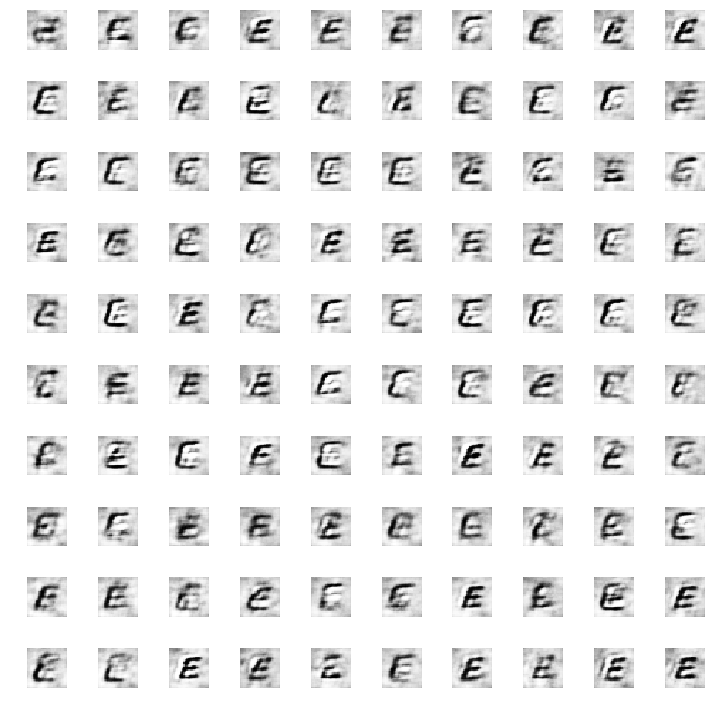

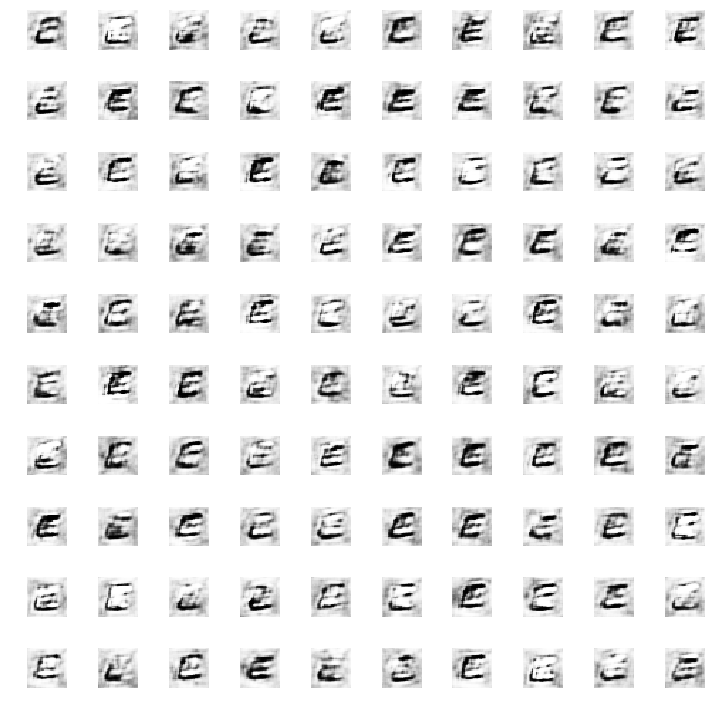

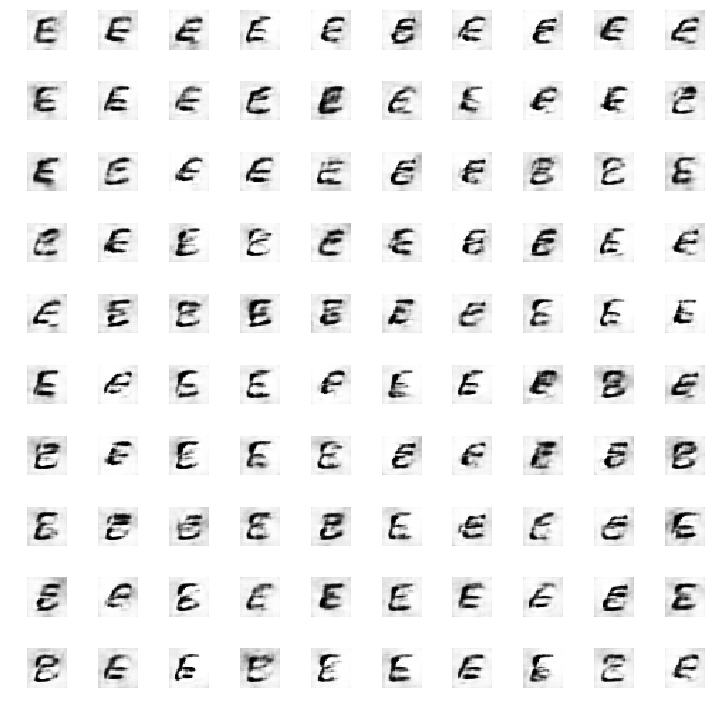

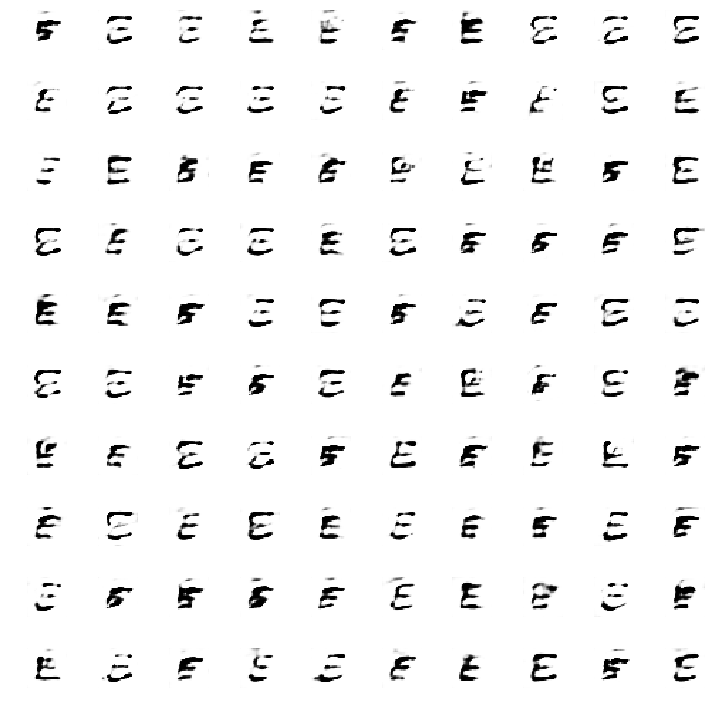

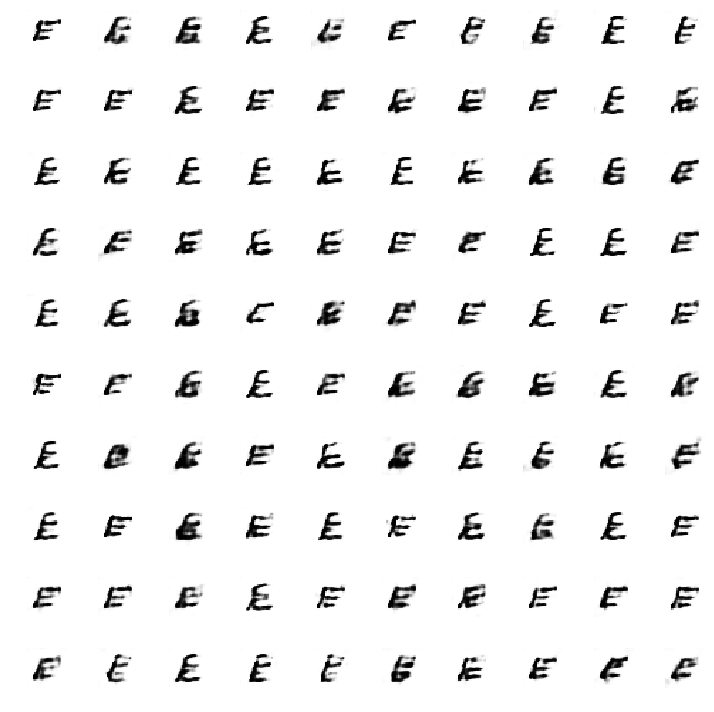

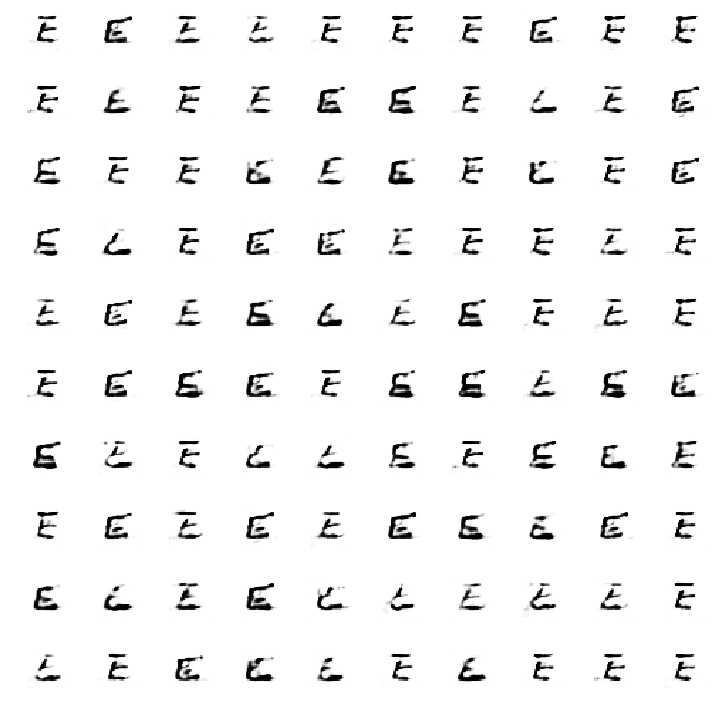

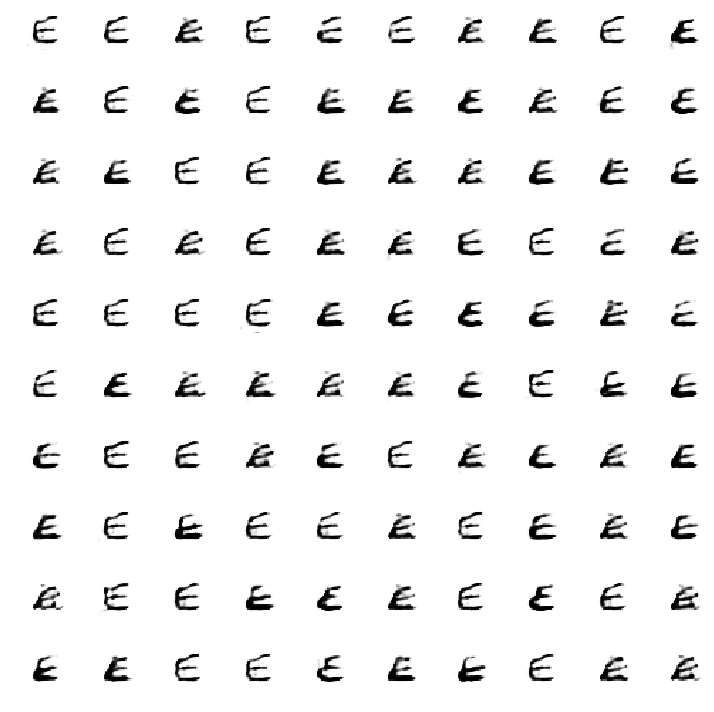

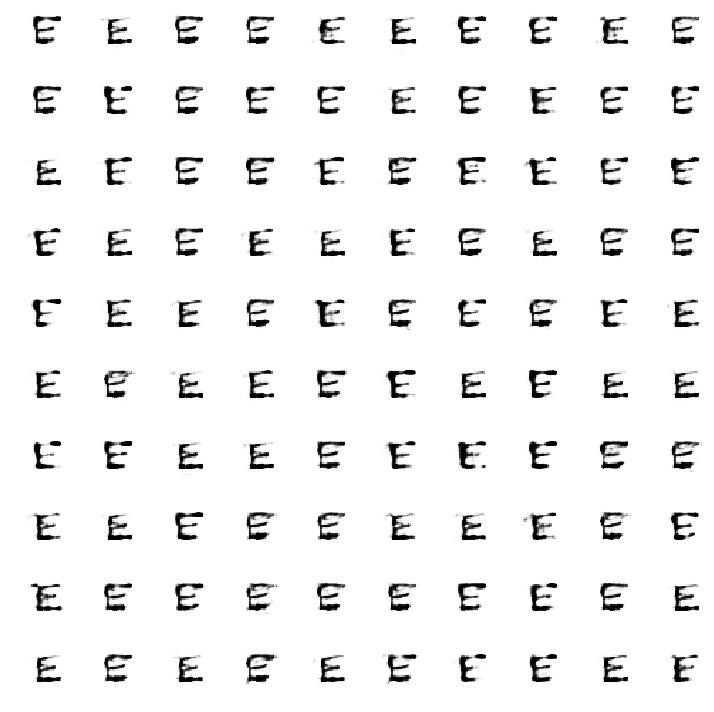

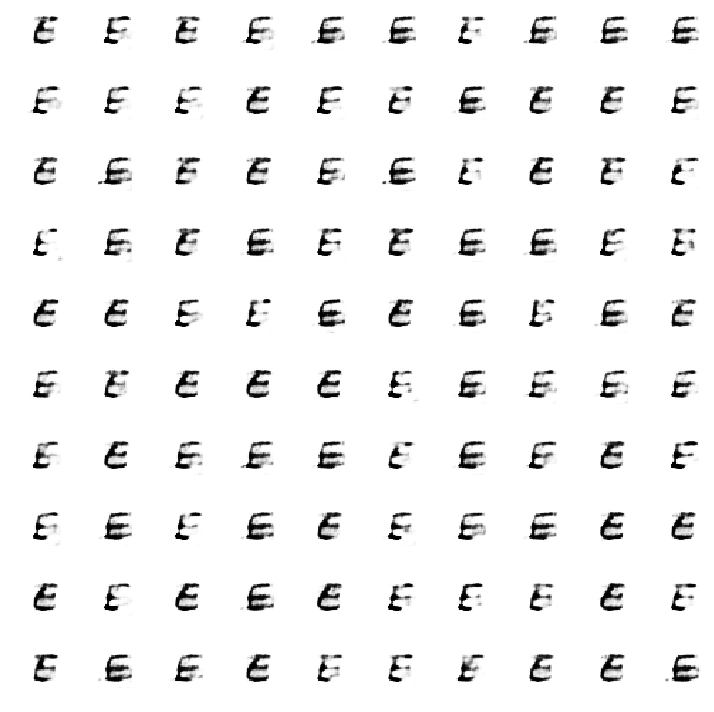

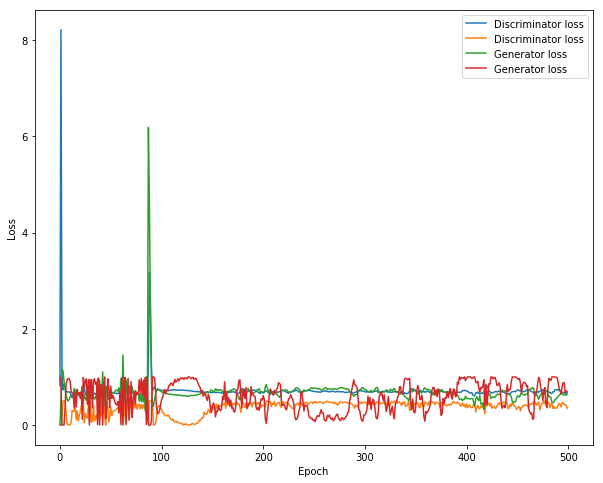

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


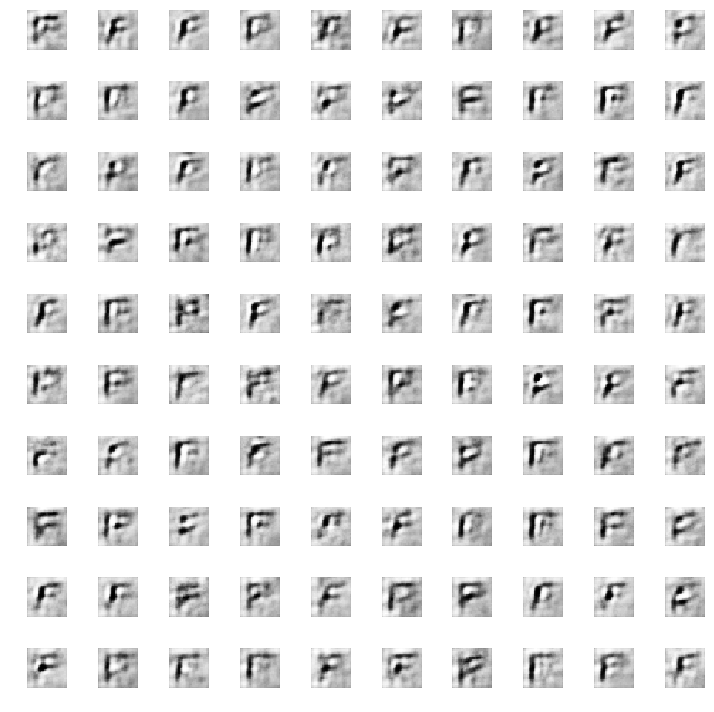

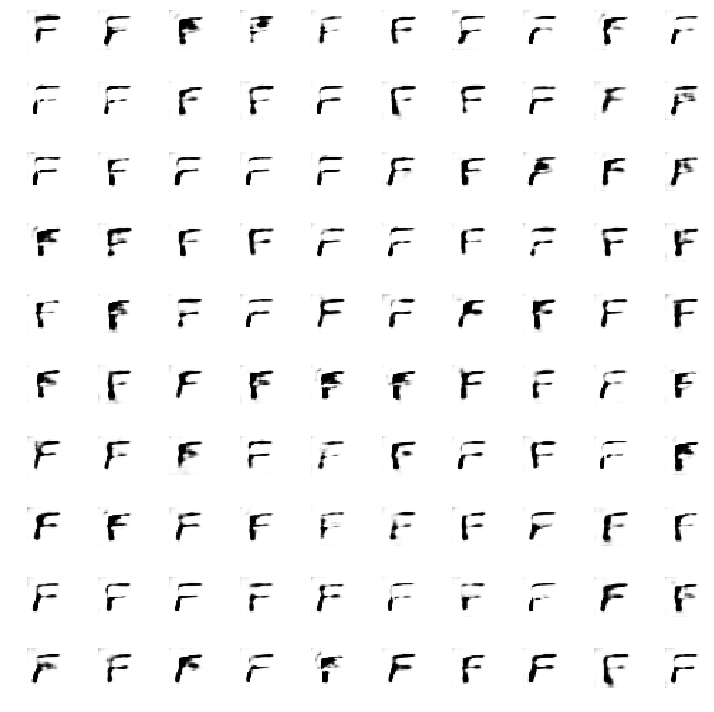

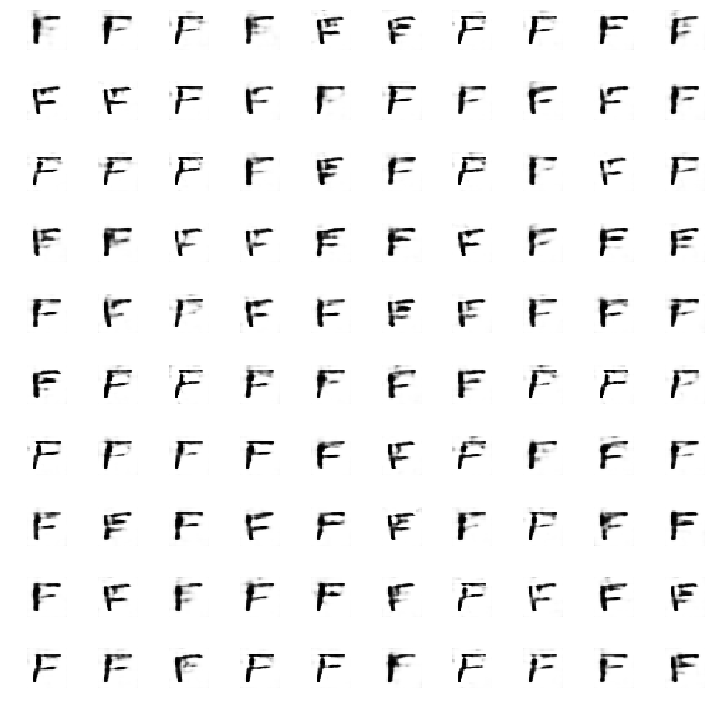

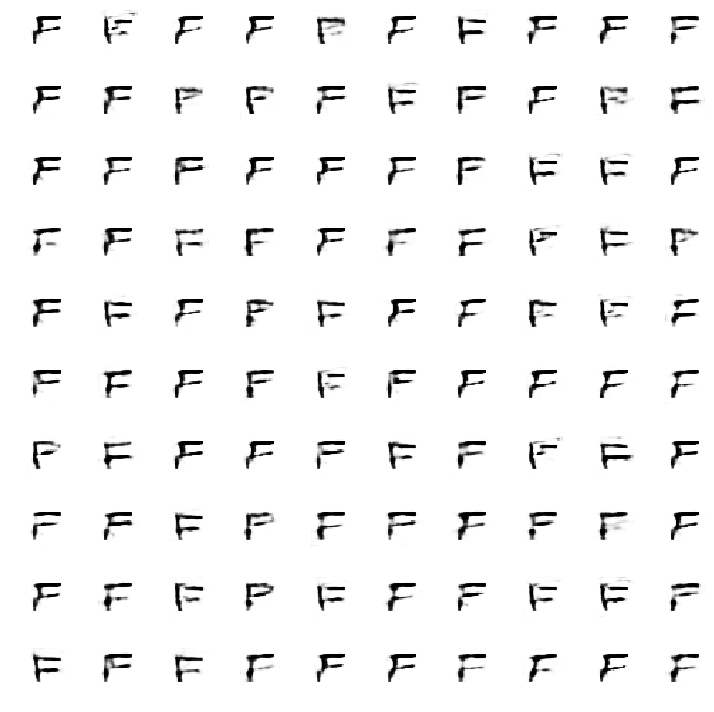

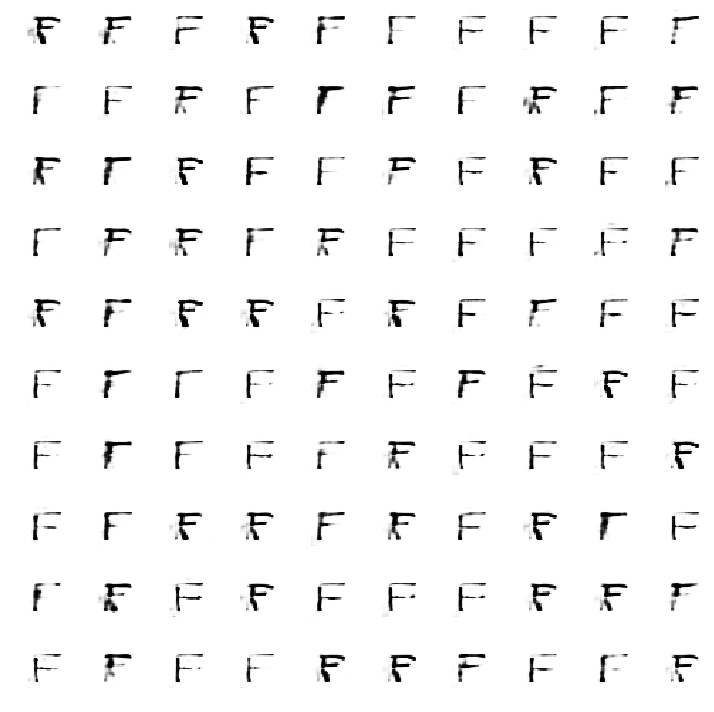

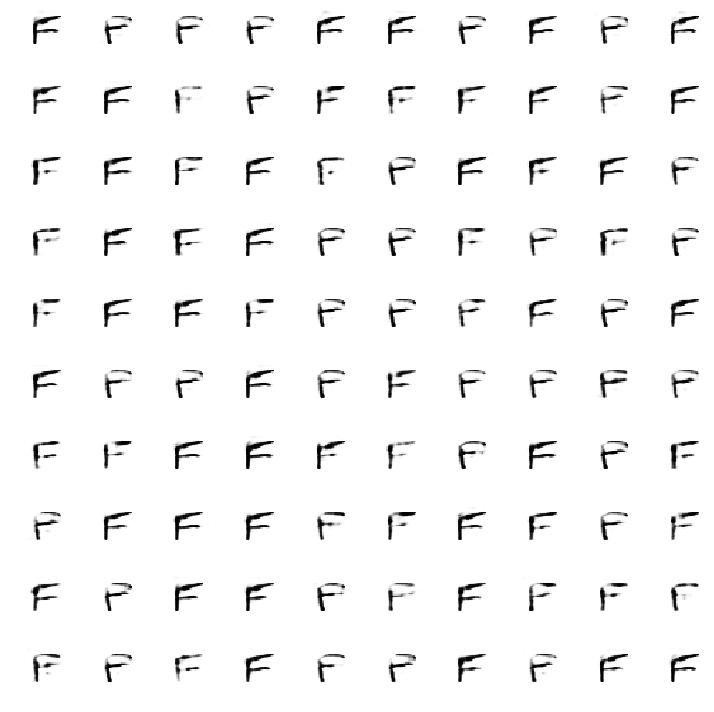

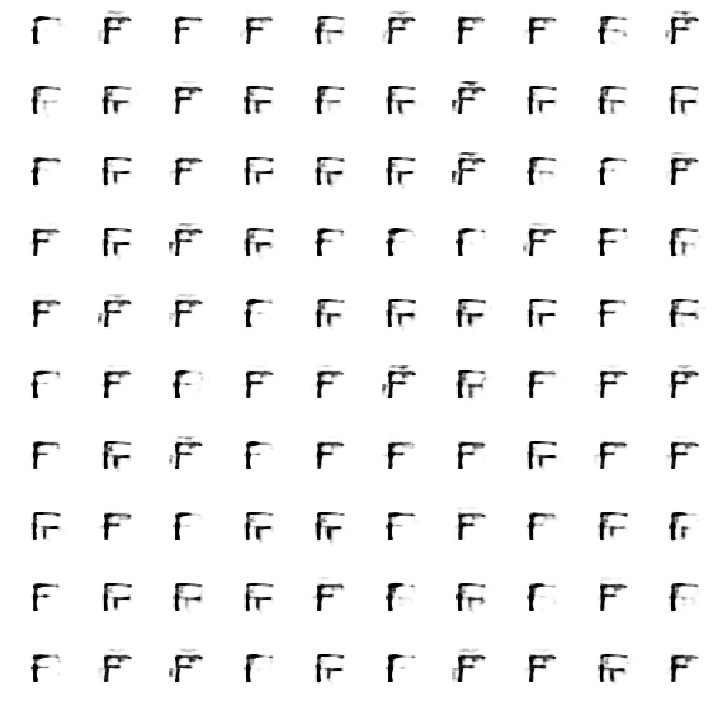

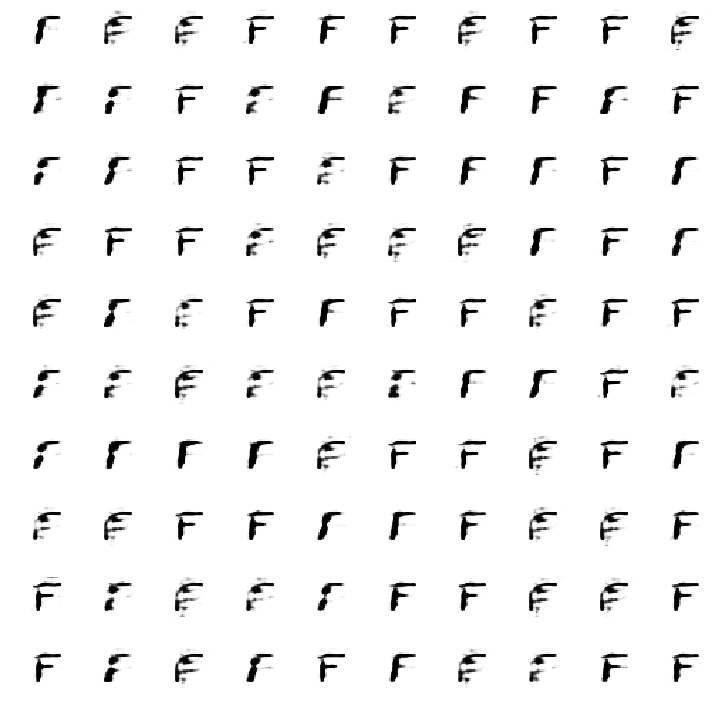

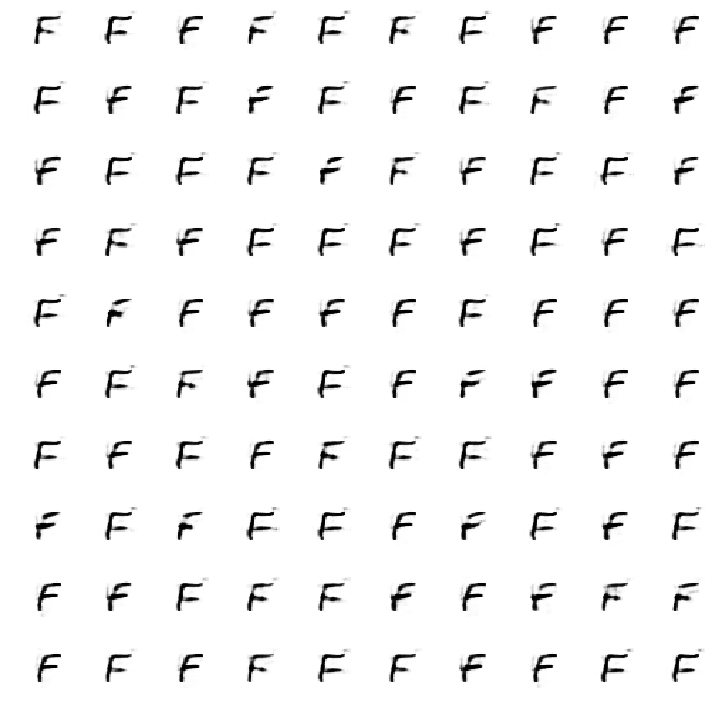

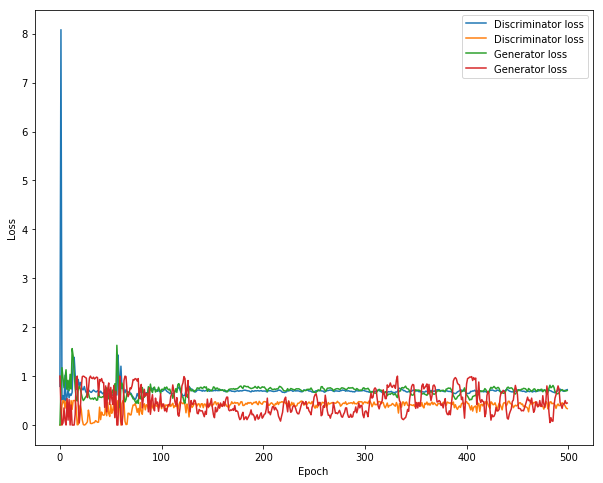

In [0]:
def main():
    # set hyper parameters    
    batch_size = 100
    epochs = 500
    learning_rate = 0.0001
    z_input_dim = 100
    n_iter_D = 1
    n_iter_G = 10

    # run model
    target_list = [['E',4],['F',5]]
    for target in target_list:
        dataset = all_dataset.loc[all_dataset['0'] == target[1]]
        dataset.rename(columns={'0':'label'}, inplace=True)

        X = dataset.drop('label',axis = 1)
        y = dataset['label']

        X_train, X_test, y_train, y_test = train_test_split(X,y)

        standard_scaler = MinMaxScaler()
        standard_scaler.fit(X_train)

        X_train = standard_scaler.transform(X_train)
        X_test = standard_scaler.transform(X_test)

        X_train = X_train.reshape(X_train.shape[0], 28, 28).astype('float32')
        X_test = X_test.reshape(X_test.shape[0], 28, 28).astype('float32')

        y_train = np_utils.to_categorical(y_train)
        y_test = np_utils.to_categorical(y_test)
        X_train = np.multiply(X_train, 255.)

        model = Model(batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G, target[0], X_train)
        model.fit()


if __name__ == '__main__':
    main()

## 참고 : 모델 시각화

In [0]:
!apt-get install graphviz
!pip install -q pydot
!pip install graphviz


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3 libgraphite2-3
  libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7 libpango-1.0-0
  libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4 libpixman-1-0
  libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0 libxcb-shm0
  libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgraphite2-3 libgvc6 libgvpr2 libharfbuzz0b libjbig0 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 28 newly installed, 0 to remove and 0 not upgraded.
Need to get 4,122 kB of archives.
After this operation, 2

Using TensorFlow backend.


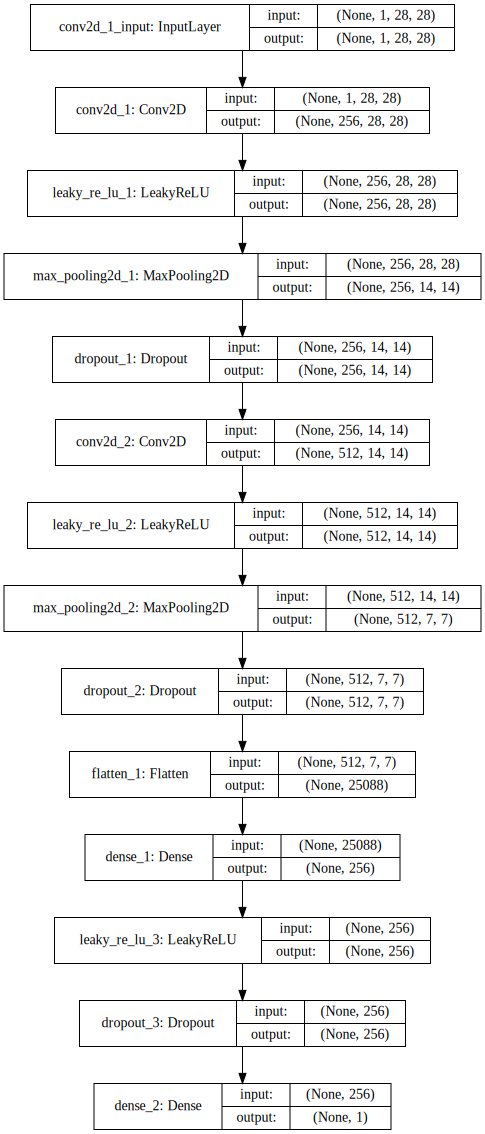

In [0]:
D = Sequential()
D.add(Conv2D(256, (5, 5),
         padding='same',
         input_shape=(1, 28, 28),
         kernel_initializer=initializers.RandomNormal(stddev=0.02)))
D.add(LeakyReLU(0.2))
D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
D.add(Dropout(0.3))
D.add(Conv2D(512, (5, 5), padding='same'))
D.add(LeakyReLU(0.2))
D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
D.add(Dropout(0.3))
D.add(Flatten())
D.add(Dense(256))
D.add(LeakyReLU(0.2))
D.add(Dropout(0.3))
D.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0002, beta_1=0.5)
D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

%matplotlib inline

SVG(model_to_dot(D, show_shapes=True).create(prog='dot', format='svg'))

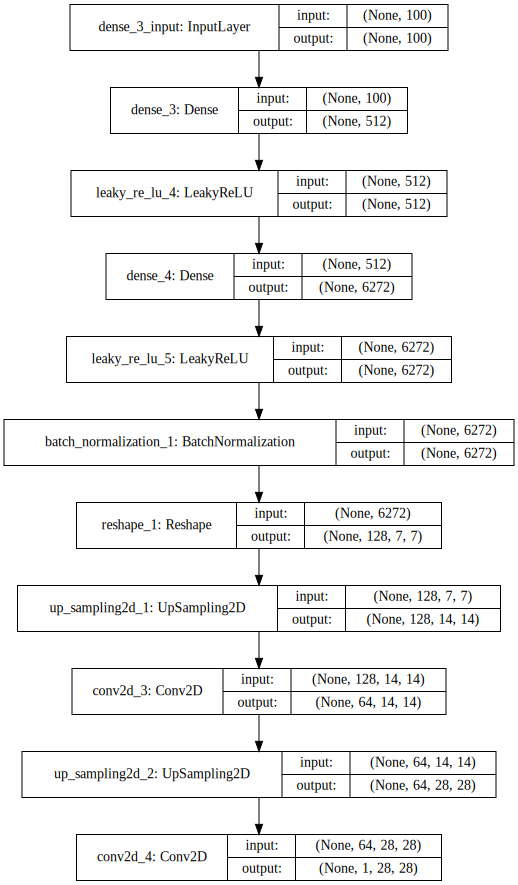

In [0]:
G = Sequential()
G.add(Dense(512, input_dim=100))
G.add(LeakyReLU(0.2))
G.add(Dense(128 * 7 * 7))
G.add(LeakyReLU(0.2))
G.add(BatchNormalization())
G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

adam = Adam(lr=0.0002, beta_1=0.5)
G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

%matplotlib inline

SVG(model_to_dot(G, show_shapes=True).create(prog='dot', format='svg'))